<a href="https://colab.research.google.com/github/rubycho/cv-notes/blob/master/CV04/CV04%20GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## GAN (Generative Adversarial Network)

Let's design a GAN with keras.

We will use Fashion MNIST dataset.
- Generator will generate Fashion MNIST-like image.
- Discriminator will discriminate whether the image is real or not.

### Prepare fashion MNIST dataset

In [1]:
import numpy as np

from tensorflow.keras.datasets import fashion_mnist


(x_train, y_train), _ = fashion_mnist.load_data()

# select images of specific object; 1 = trousers
y_class = 1
x_train = x_train[np.where(y_train == y_class)[0]]

# resize as [-1, 1]
x_train = (np.float32(x_train) - 127.5) / 127.5

4423680/4422102 [==============================] - 0s 0us/step


In [2]:
print(x_train[0].shape)

(28, 28)


### Build Generator

We will set latent space as R^64.

In [3]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten

def build_generator():
  """
  latent vector (64,) => image (28, 28)
  apply tanh on last activation, cause we normalized the x_train.
  """

  i = Input(shape=(64,))
  x = Dense(128, activation='relu')(i)
  x = Dense(256, activation='relu')(x)
  x = Dense(512, activation='relu')(x)
  x = Dense(28*28, activation='tanh')(x)
  x = Reshape((28, 28))(x)

  return Model(inputs=i, outputs=x)

gen = build_generator()
gen.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
dense (Dense)                (None, 128)               8320      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_3 (Dense)              (None, 784)               402192    
_________________________________________________________________
reshape (Reshape)            (None, 28, 28)            0         
Total params: 575,120
Trainable params: 575,120
Non-trainable params: 0
________________________________________________

### Build Discriminator

In [4]:
def build_discriminator():
  """
  image (28, 28) => 0 or 1
  """

  i = Input(shape=(28,28))
  x = Flatten()(i)
  x = Dense(128, activation='relu')(x)
  x = Dense(256, activation='relu')(x)
  x = Dense(512, activation='relu')(x)
  x = Dense(1, activation='sigmoid')(x)

  return Model(inputs=i, outputs=x)

dis = build_discriminator()
dis.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_5 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_6 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 513       
Total params: 265,601
Trainable params: 265,601
Non-trainable params: 0
________________________________________________

### Compile model

Note that discriminator trainable is set to False, after `compile` of discriminator.

In [5]:
dis.compile(optimizer='adam', loss='binary_crossentropy')
dis.trainable = False

gen_dis = Sequential([gen, dis])
gen_dis.summary()

gen_dis.compile(optimizer='adam', loss='binary_crossentropy')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_1 (Functional)    (None, 28, 28)            575120    
_________________________________________________________________
functional_3 (Functional)    (None, 1)                 265601    
Total params: 840,721
Trainable params: 575,120
Non-trainable params: 265,601
_________________________________________________________________


### Train G-D

I trained with only 500 epochs.

0 epoch / 500 epochs


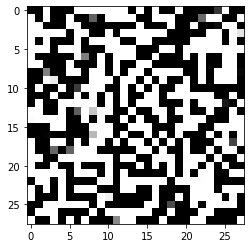

100 epoch / 500 epochs


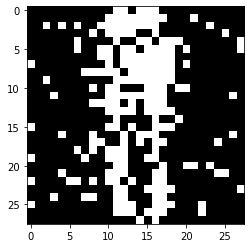

200 epoch / 500 epochs


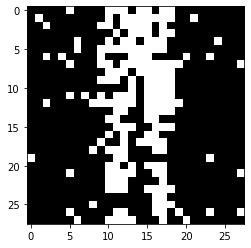

300 epoch / 500 epochs


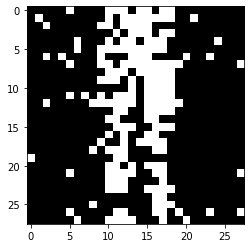

400 epoch / 500 epochs


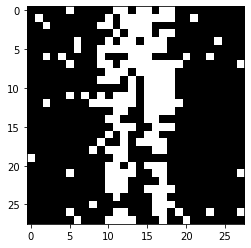

In [6]:
import matplotlib.pyplot as plt

epochs = 500
batch = x_train.shape[0]

for epoch in range(epochs):
  latent = np.random.normal(0, 1, (batch, 64))
  gen_dis.fit(x=latent, y=np.ones(batch), verbose=0)

  fake_imgs = gen.predict(latent)
  if epoch % 100 == 0:
    print("%d epoch / %d epochs" % (epoch, epochs))
    plt.imshow(fake_imgs[0], cmap='gray')
    plt.show()

  dis.fit(x=fake_imgs, y=np.zeros(batch), verbose=0)
  dis.fit(x=x_train, y=np.ones(batch), verbose=0)

### Compare two images

<Figure size 432x288 with 0 Axes>

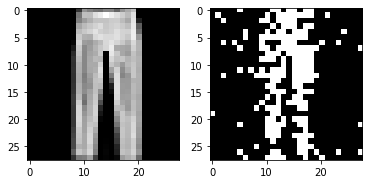

In [7]:
plt.figure()
plt.subplots(1, 2)

plt.subplot(1, 2, 1)
plt.imshow(x_train[0], cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(fake_imgs[0], cmap='gray')